# Chapter 3 - Classification

We'll look at the `MNIST` dataset of handwritten digits and perform classification tasks on it (inferring which digit 0-9 is represented by the image).

In [93]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.base import clone
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, f1_score,
    precision_recall_curve, precision_score, recall_score,
    roc_auc_score, roc_curve,
)
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [82]:
mnist = fetch_openml('mnist_784', as_frame=False, data_home='~/.scikit_learn_data')

print('Shape:', mnist.data.shape)
print()
print('Data:')
print(mnist.data)
print()
print('Target:')
print(mnist.target)
print('Min/Max of One Digit:')
print(mnist.data[0].min(), mnist.data[0].max())
print()

Shape: (70000, 784)

Data:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Target:
['5' '0' '4' ... '4' '5' '6']
Min/Max of One Digit:
0 255



In [3]:
def plot_digit(image_data: np.ndarray):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap='binary')
    plt.axis('off')

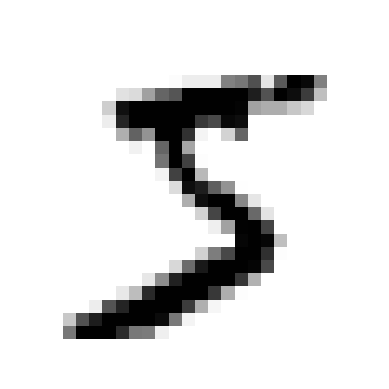

In [4]:
X, y = mnist.data, mnist.target
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

some_digit = some_digit_5 = X_train[0]
assert y_train[0] == '5'

plot_digit(some_digit_5)

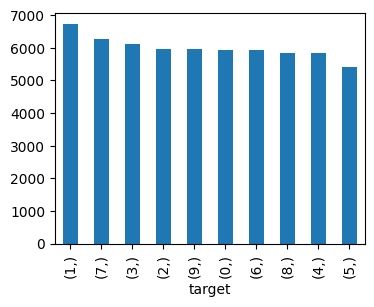

In [5]:
pd.DataFrame(y_train, columns=['target']).value_counts().plot.bar(figsize=(4, 3))
plt.show()

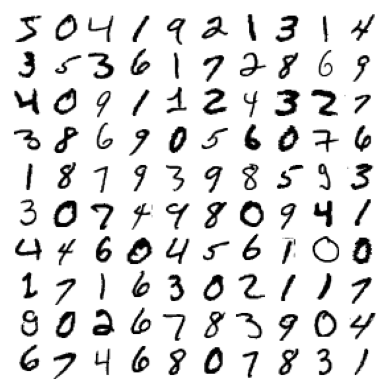

In [107]:
def plot_more_digits(one_hundred_digits):
    image = (
        one_hundred_digits.reshape(10, 10, 28, 28)
        .transpose(0, 2, 1, 3)
        .reshape(280, 280)
    )
    plt.imshow(image, cmap='binary')
    plt.axis('off')

plot_more_digits(X_train[:100])

In [7]:
# We'll use these to detect the digit 5.
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [8]:
sgd_clf = SGDClassifier(random_state=42, n_jobs=-1)
sgd_clf.fit(X_train, y_train_5)
pass

In [9]:
# This should be true because we have a 5.
sgd_clf.predict([some_digit_5])

array([ True])

In [10]:
# These values look nice, but accuracy is not always a preferred performance measure.
# E.g. if you just guessed that all digits are not 5, then you're already at 90% accuracy.
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy', n_jobs=-1)

array([0.95035, 0.96035, 0.9604 ])

In [11]:
# Custom cross validation scoring for our edification!

skfolds = StratifiedKFold(n_splits=3)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [79]:
# This splits the training into 3 potentially overlapping training folds. However, the targets
# in the test sets are split into 3 non-overlapping folds so that each sample has one predicted value.
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, n_jobs=-1)

In [13]:
# We can use these predictions to evaluate how well our model performes by considering a confusion matrix.
# Each row corresponds to actual class.
# Each column corresponds to predicted class.
cm = confusion_matrix(y_train_5, y_train_pred)
tp = cm[1, 1]  # True Positive
fp = cm[0, 1]  # False Positive
tn = cm[0, 0]  # True Negative
fn = cm[1, 0]  # False Negative
precision = tp / (tp + fp)
recall = tp / (fn + tp)
f1 = 2 / (1 / precision + 1 / recall)  # Harmonic mean of precision and recall.

print(cm)
print()
print('non-fives predicted to be non-fives:     ', tn)  # True Negative
print('non-fives predicted to be fives (Type 1):', fp)  # False Positive
print('fives predicted to be non-fives (Type 2):', fn)  # False Negative
print('fives predicted to be fives:             ', tp)  # True Positive
print()
print('precision:', precision)
print('recall:   ', recall)
print('f1 score: ', f1)

del precision
del recall
del f1

[[53892   687]
 [ 1891  3530]]

non-fives predicted to be non-fives:      53892
non-fives predicted to be fives (Type 1): 687
fives predicted to be non-fives (Type 2): 1891
fives predicted to be fives:              3530

precision: 0.8370879772350012
recall:    0.6511713705958311
f1 score:  0.7325171197343847


In [14]:
# Of course, there are functions for these metrics.
print('precision:', precision_score(y_train_5, y_train_pred))
print('recall:   ', recall_score(y_train_5, y_train_pred))
print('f1 score: ', f1_score(y_train_5, y_train_pred))

precision: 0.8370879772350012
recall:    0.6511713705958311
f1 score:  0.7325171197343847


In [15]:
# The SGDClassificer uses some threshold internally for decising whether a sample is
# in the target class or not. We can't see that threshold; however, we can use the
# decision function from the classifier to get a sample's score and use our own threshold.
y_scores = sgd_clf.decision_function([some_digit_5])
y_scores

array([2164.22030239])

In [16]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [17]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [80]:
# We can use cross_val_predict to get at these decsion_function() values.
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function', n_jobs=-1)

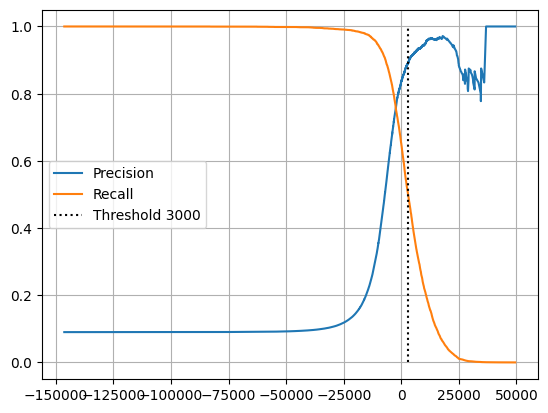

In [19]:
# Then we can compute precision and recall for various thresholds with the
# precision_recall_curve() function.
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.vlines(threshold, 0, 1.0, 'black', 'dotted', label='Threshold ' + str(threshold))
plt.grid(True)
plt.legend()
plt.show()

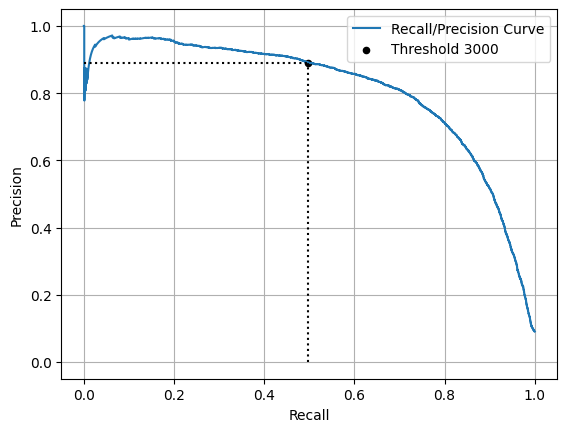

In [20]:
plt.plot(recalls, precisions, label='Recall/Precision Curve')
index = sum(thresholds < threshold)
plt.hlines(precisions[index], 0.0, recalls[index], 'black', 'dotted')
plt.vlines(recalls[index], 0.0, precisions[index], 'black', 'dotted')
plt.scatter([recalls[index]], [precisions[index]], c='black', s=20, label='Threshold ' + str(threshold))
plt.legend()
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.grid(True)
plt.show()

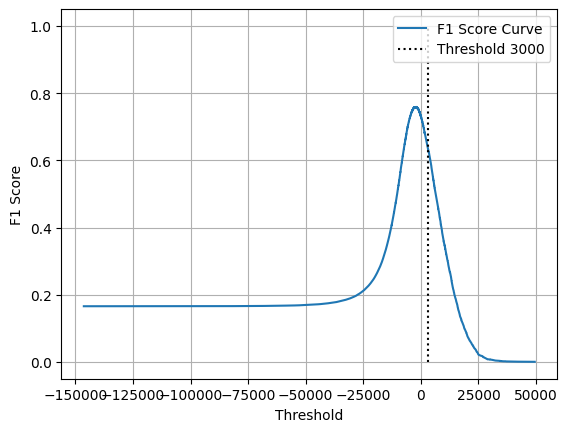

In [21]:
# Are the f1 scores interesting as a plot?
f1s = 2 / (1 / precisions[:-1] + 1 / recalls[:-1])
plt.plot(thresholds, f1s, label='F1 Score Curve')
plt.vlines(threshold, 0.0, 1.0, 'black', 'dotted', label='Threshold ' + str(threshold))
plt.grid(True)
plt.ylabel('F1 Score')
plt.xlabel('Threshold')
plt.legend()
plt.show()

In [22]:
# We can use the precisions or recalls calculated this way to find the threshold
# we are interested in.
idx_for_90_precision = (precisions > 0.90).argmax()  # First index of largest item.
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

np.float64(3370.0194991439557)

In [23]:
# Instead of using the classifier's predict method, we can now just run this:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)
print('precision:', precision_score(y_train_5, y_train_pred_90))
print('recall:   ', recall_score(y_train_5, y_train_pred_90))
print('f1 score: ', f1_score(y_train_5, y_train_pred_90))

precision: 0.9000345901072293
recall:    0.4799852425751706
f1 score:  0.6260827718960539


In [24]:
# The Receive Operating Characteristic (ROC) curve is commonly used with binary classifiers.
# fpr - False Positive Rate (Fall-Out)
# tpr - True Positive Rate (Recall)
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

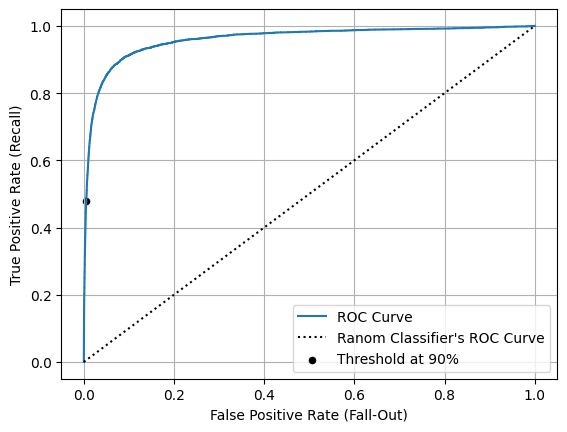

In [25]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0, 1], [0, 1], "k:", label="Ranom Classifier's ROC Curve")
plt.scatter([fpr_90], [tpr_90], c="black", s=20, label="Threshold at 90%")
plt.xlabel("False Positive Rate (Fall-Out)")
plt.ylabel("True Positive Rate (Recall)")
plt.grid(True)
plt.legend()
plt.show()

In [26]:
# It's reasonable to measure the area under the ROC curve (ROC AUC) as a measure of
# how well a model performs.
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [27]:
# Since 5s are more rare than other items in our samples, the precision/recall curve is more
# appropriate for assessing the model.
#
# Rule of tumb--use the recision/recall curve when:
#
# * The positive class is rare (what we have here).
# * You care more about the false positive rate than the false negative rate.
#
# Otherwise, use the ROC curve.

In [28]:
forest_clf = RandomForestClassifier(random_state=42)

In [29]:
# RandomForestClassifier doesn't have a decision_function(), but it can predict the probability
# that the sample is in the class with its predict_proba() method.
y_probas_forest = cross_val_predict(
    forest_clf, X_train, y_train_5, cv=3,
    method="predict_proba", n_jobs=-1,
)
y_probas_forest[:3]

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04]])

In [30]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, threshold_forest = precision_recall_curve(
    y_train_5, y_scores_forest,
)

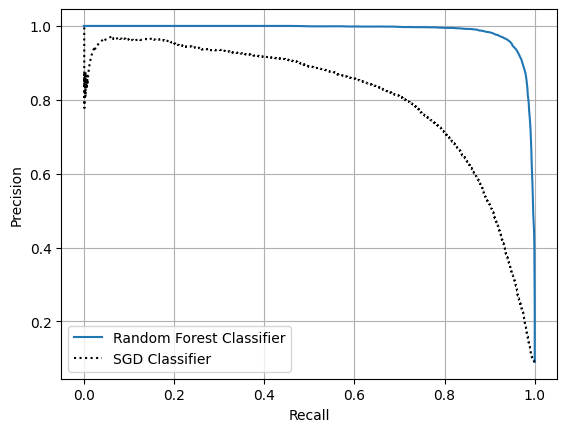

In [31]:
plt.plot(recalls_forest, precisions_forest, label="Random Forest Classifier")
plt.plot(recalls, precisions, 'k:', label="SGD Classifier")
plt.grid(True)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

In [32]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # More likely a 5 than not.
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [33]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [34]:
print('precision:', precision_score(y_train_5, y_train_pred_forest))
print('recall:   ', recall_score(y_train_5, y_train_pred_forest))

precision: 0.9897468089558485
recall:    0.8725327430363402


In [67]:
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])

svm_clf.predict([some_digit_5])

array(['5'], dtype=object)

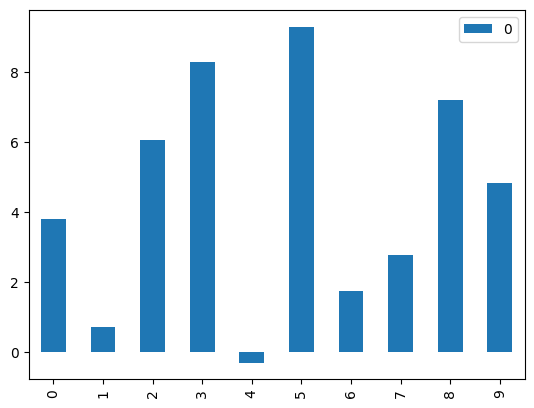

In [60]:
some_digit_scores = svm_clf.decision_function([some_digit_5])
pd.DataFrame(some_digit_scores, columns=[str(x) for x in range(10)]).transpose().plot.bar()
plt.show()

In [64]:
print(svm_clf.classes_)

class_id = some_digit_scores.argmax()
print("prediction:", svm_clf.classes_[class_id])

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
prediction: 5


In [70]:
ovr_clf = OneVsRestClassifier(SVC(random_state=42), n_jobs=-1)
ovr_clf.fit(X_train[:2000], y_train[:2000])

ovr_clf.predict([some_digit_5])

array(['5'], dtype='<U1')

In [71]:
len(ovr_clf.estimators_)

10

In [73]:
sgd_clf = SGDClassifier(random_state=42, n_jobs=-1)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit_5])

array(['3'], dtype='<U1')

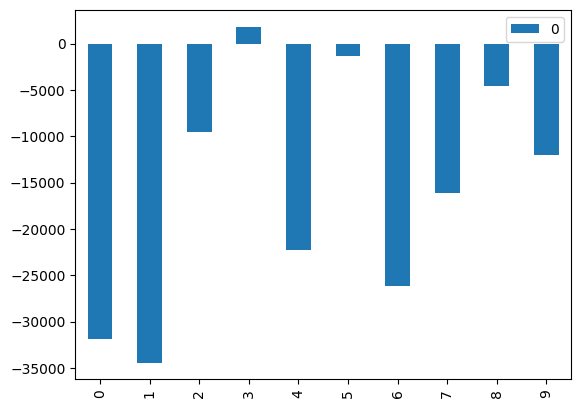

In [76]:
some_digit_scores = sgd_clf.decision_function([some_digit_5])
pd.DataFrame(some_digit_scores, columns=[str(x) for x in range(10)]).transpose().plot.bar()
plt.show()

In [78]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy", n_jobs=-1)

array([0.87365, 0.85835, 0.8689 ])

In [83]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy", n_jobs=-1)

array([0.8983, 0.891 , 0.9018])

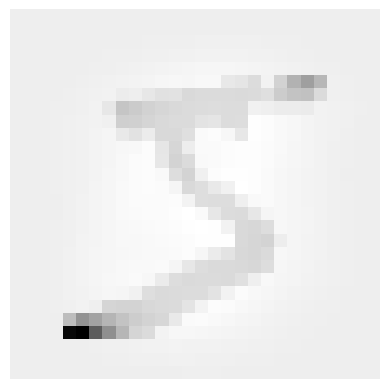

In [92]:
plot_digit(X_train_scaled[0])

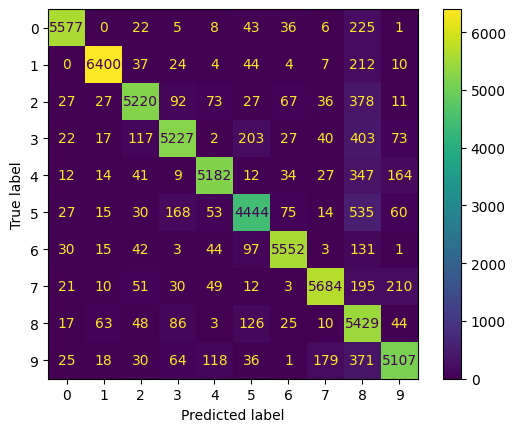

In [94]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3, n_jobs=-1)

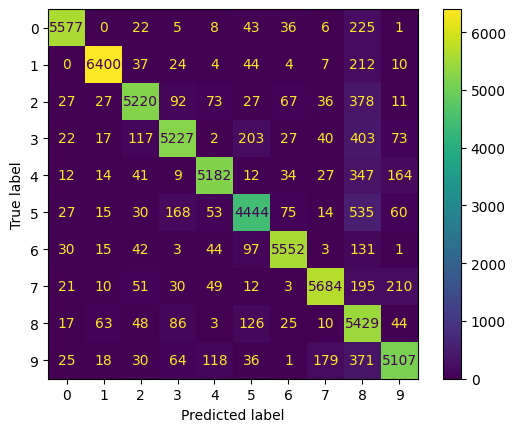

In [95]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

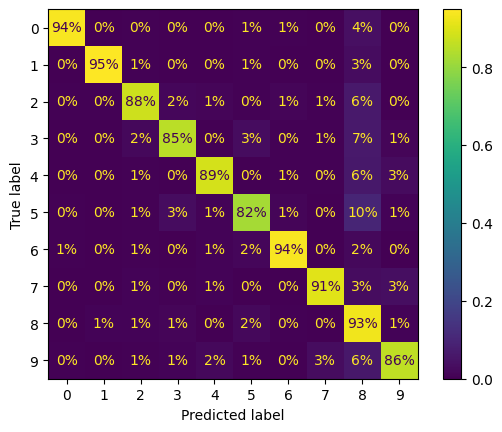

In [96]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize="true", values_format=".0%")
plt.show()

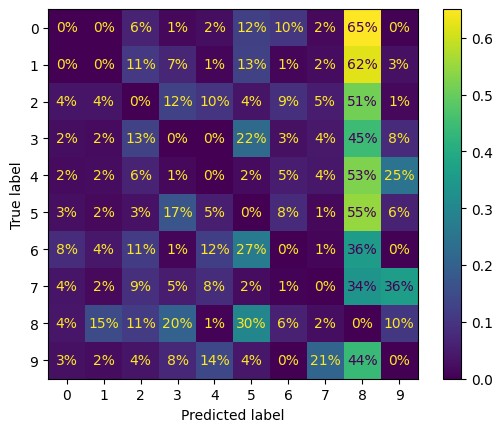

In [99]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(
    y_train, y_train_pred,
    sample_weight=sample_weight, normalize="true", values_format=".0%",
)
plt.show()

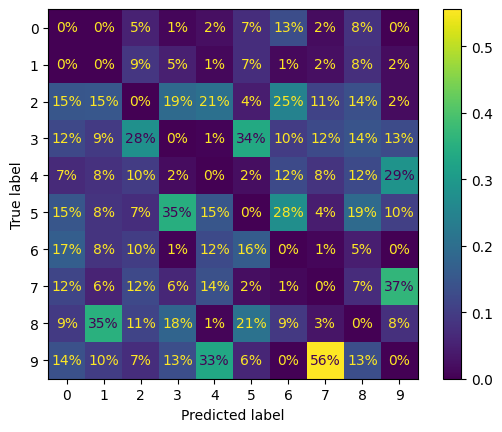

In [101]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(
    y_train, y_train_pred,
    sample_weight=sample_weight, normalize="pred", values_format=".0%",
)
plt.show()

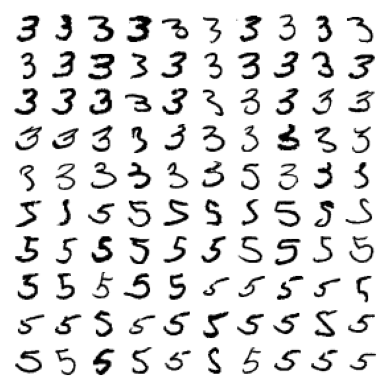

In [112]:
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

XX_abab = np.concat([X_aa[:25], X_ab[:25], X_ba[:25], X_bb[:25]])
plot_more_digits(XX_abab)

# HOMEWORK: Put labels on the image and guide lines